In [23]:
from IPython.display import display, clear_output
from datetime import datetime
import time
import pytz
from pathlib import Path

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DataType
import pyspark.sql.functions as sf
from pyspark.sql.functions import lit, date_format, col, udf


#Visualization libraries
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib.pyplot import figure
import matplotlib

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

%matplotlib inline

# Plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
from plotly.graph_objs import Layout


import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [9]:
# Create SparkSession
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [10]:
## Create the schema of the value field for Car Park Facility
schema_car_park_facility_stream = StructType([
    StructField("facility_id", StringType(),  True),
    StructField("tsn", StringType(),  True),
    StructField("park_id", StringType(),  True),
    StructField("facility_name", StringType(),  True),
    StructField("time", StringType(),  True),
    StructField("spots", StringType(),  True),
    StructField("message_date", StringType(),  True),
    StructField("tfnsw_facility_id", StringType(), True),
    StructField("facility_occupancy_loop", StringType(), True),
    StructField("facility_occupancy_total", StringType(), True),
    StructField("facility_occupancy_monthlies", StringType(),  True),
    StructField("facility_occupancy_open_gate", StringType(), True),
    StructField("facility_occupancy_transients", StringType(), True),
])

In [19]:
### Subscribe the topic "nsw_car_park_facility" from the Kafka broker and 
### Read the earlierst data into the Spark dataframe called car_park_facility_stream_df
car_park_facility_stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "earliest") \
  .option("subscribe", "nsw_car_park_facility") \
  .load()

### Convert the columns key and value from stream_df to string and 
### Save the results into the dataframe again
car_park_facility_stream_df = car_park_facility_stream_df \
    .withColumn("key", car_park_facility_stream_df["key"].cast(StringType())) \
    .withColumn("value", car_park_facility_stream_df["value"].cast(StringType()))

### Convert the column value of string_stream_df to JSON and
### Save the results to the dataframe again 
car_park_facility_stream_df = car_park_facility_stream_df \
    .withColumn("value", F.from_json("value", schema_car_park_facility_stream))

### Flatten the columns from value and rename the columns key, topic, timestamp to respectively event_key, event_topic, event_timestamp
car_park_facility_stream_df = car_park_facility_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.facility_id", \
        "value.tsn", \
        "value.park_id", \
        "value.facility_name", \
        "value.time", \
        "value.spots", \
        "value.message_date", \
        "value.tfnsw_facility_id", \
        "value.facility_occupancy_loop", \
        "value.facility_occupancy_total", \
        "value.facility_occupancy_monthlies", \
        "value.facility_occupancy_open_gate", \
        "value.facility_occupancy_transients"
    )

### Drop duplicate records
car_park_facility_stream_df = car_park_facility_stream_df.dropDuplicates(["facility_id","message_date"])

### Print the schema of car_park_facility_stream_df
car_park_facility_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- facility_id: string (nullable = true)
 |-- tsn: string (nullable = true)
 |-- park_id: string (nullable = true)
 |-- facility_name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- spots: string (nullable = true)
 |-- message_date: string (nullable = true)
 |-- tfnsw_facility_id: string (nullable = true)
 |-- facility_occupancy_loop: string (nullable = true)
 |-- facility_occupancy_total: string (nullable = true)
 |-- facility_occupancy_monthlies: string (nullable = true)
 |-- facility_occupancy_open_gate: string (nullable = true)
 |-- facility_occupancy_transients: string (nullable = true)



In [20]:
## config window parameters
WINDOW_DURATION = '300 seconds'
SLIDE_DURATION = '60 seconds'
WATERMARK_DURATION = "5 minutes"

In [16]:
# Create window stream with watermark
windowed_facility_occupancy_mean_stream_df = car_park_facility_stream_df \
    .withWatermark("event_timestamp", WATERMARK_DURATION) \
    .groupBy(F.window(car_park_facility_stream_df.event_timestamp, WINDOW_DURATION, SLIDE_DURATION), car_park_facility_stream_df.facility_id) \
    .agg(sf.max("facility_name").alias("facility_name"), sf.mean("facility_occupancy_total").alias("facility_occupancy_mean"), sf.mean("spots").alias("spots")) \
    .withColumn("start_time", col("window.start")) \
    .withColumn("end_time", col("window.end"))

# calculate availability percentages
windowed_facility_occupancy_mean_stream_df = windowed_facility_occupancy_mean_stream_df \
    .withColumn("availability_percentage", (windowed_facility_occupancy_mean_stream_df["spots"] - windowed_facility_occupancy_mean_stream_df["facility_occupancy_mean"])*100.0 / windowed_facility_occupancy_mean_stream_df["spots"] )

In [17]:
windowed_facility_occupancy_mean_stream = windowed_facility_occupancy_mean_stream_df \
    .writeStream \
    .format("memory") \
    .outputMode("Complete") \
    .queryName("windowed_facility_occupancy_mean_view") \
    .start()

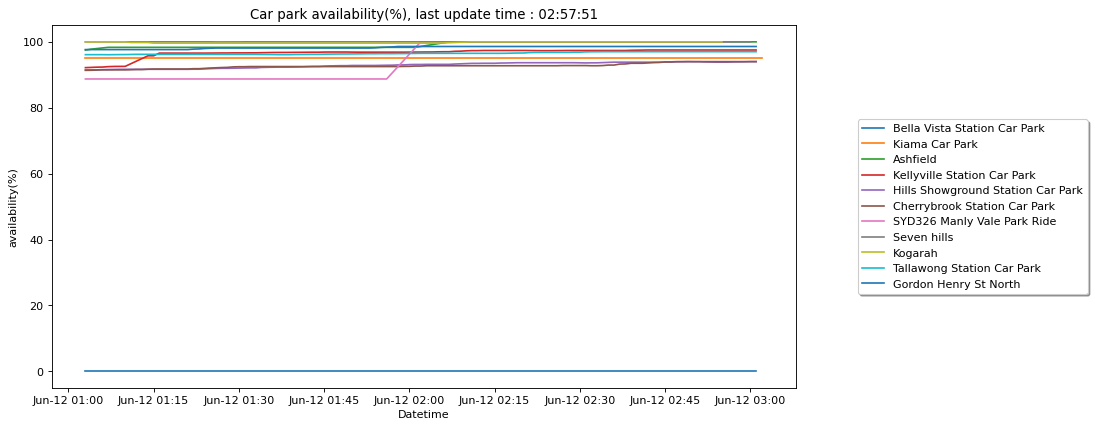

In [49]:
try:
    while True:
        clear_output(wait=True)
        
        # get last two hours records only
        windowed_facility_state_df = spark.sql(f"""
            SELECT 
                start_time, 
                end_time, 
                facility_id, 
                facility_name, 
                facility_occupancy_mean, 
                spots, 
                availability_percentage 
            FROM 
                windowed_facility_occupancy_mean_view where start_time > (current_timestamp() - INTERVAL 2 hours) 
            ORDER BY start_time
        """)
        
        if windowed_facility_state_df.count() > 0:
        
            # convert spark dataframe to pandas dataframe
            windowed_facility_state_pd_df = windowed_facility_state_df.toPandas()
            
            # change timezone to Sydney time
            windowed_facility_state_pd_df["start_time"] = windowed_facility_state_pd_df["start_time"].dt.tz_localize('utc').dt.tz_convert('Australia/Sydney')
            windowed_facility_state_pd_df["end_time"] = windowed_facility_state_pd_df["end_time"].dt.tz_localize('utc').dt.tz_convert('Australia/Sydney')
            #display(windowed_facility_state_pd_df)

            # get all facilities
            all_facilities = windowed_facility_state_pd_df['facility_name'].unique().tolist()

            # get current time
            tz = pytz.timezone('Australia/Sydney')
            now = datetime.now(tz)
            current_time = now.strftime("%H:%M:%S")

            # plot graph
            figure(figsize=(12, 6), dpi=80)
            for facility in all_facilities:
                display_df = windowed_facility_state_pd_df.query(f"facility_name == '{facility}'").sort_values(["end_time"])      
                plt.plot('end_time', 
                         'availability_percentage', 
                         data=display_df,
                         label=facility
                        ) 

            # set plot date format
            date_form = DateFormatter("%b-%d %H:%M", tz=tz)
            ax = plt.gca()
            ax.xaxis.set_major_formatter(date_form)    
            
            # set plot layout
            plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), shadow=True, ncol=1)
            plt.ylabel("availability(%)")
            plt.xlabel("Datetime")
            plt.title(f"Car park availability(%), last update time : {current_time}")
            plt.show()
        
        time.sleep(60)
    
    
        
except KeyboardInterrupt:
    pass

In [32]:
windowed_facility_occupancy_mean_stream.stop()

In [33]:
spark.stop()